# Индекс IVFADC

## На евклидовой метрике

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
import sklearn
from tslearn.metrics import dtw
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import lb_keogh as Keogh

from numpy.linalg import norm

class IVFADC_EUCLIDIAN():
    def k_means(X,n,iter):
        model = TimeSeriesKMeans(n_clusters=n, metric="euclidean",random_state=0,max_iter=iter)
        model.fit(X)
        cluster=model.cluster_centers_
        clusters=[]
        for c in cluster:
            c=list(c.reshape(1,-1))
            c=c[0]
            clusters.append(c)
        clusters=np.array(clusters)
        return clusters
    
    def PQ(X,main_clusters,n_clusters,m_clusters,m):
        database=[[] for _ in range(n_clusters)]
        subvectors = [] # подвекторы
        nn_main_res = [] # чтобы знать результаты поиска главных центроидов
        nn = NearestNeighbors(n_neighbors=n_clusters,metric='euclidean') # создаем поиск ближайших главных центроидов
        nn.fit(main_clusters) # обучаем его
        for x in X: # для каждого вектора в X
            res=nn.kneighbors([x],n_neighbors=n_clusters,return_distance=False) # находим ближайший к нему центроид
            res=res[0][0]
            nn_main_res.append(res)    # заносим результат во временное хранилище
            x-=main_clusters[res]      # вычисляем остаток
            D = len(x)
            assert D % m == 0
            D_ = int(D / m)
            x_sub = [x[row:row+D_] for row in range(0, D, D_)] # делаем нарезку
            for sub in x_sub:
                subvectors.append(sub)                         # добавляем подвекторы в общую базу
        del x_sub,D,D_,res,nn,X
        subvectors=np.array(subvectors)
        print(len(nn_main_res))
        print('Подвекторы созданы')
        sub_clusters=IVFADC_EUCLIDIAN.k_means(subvectors,m_clusters,10) # создаем кластеры для подвекторов
        print('Кластеры для подвекторов созданы')
        nn = NearestNeighbors(n_neighbors=m_clusters,metric='euclidean') # создаем поиск ближайших подцентроидов
        nn.fit(sub_clusters) # учим его
        print('NN для подкластеров создан')
        code=[] # переменная для формирования кода PQ
        q=0
        k=0
        print(len(subvectors))
        for sub in subvectors:
            k+=1
            res=nn.kneighbors([sub],n_neighbors=m_clusters,return_distance=False) # находим ближайший центроид
            res=res[0][0]
            if k!=m:
                code.append(res)  # формируем код
            else:
                code.append(res)
                ind = nn_main_res[q]
                database[ind].append([q,code])
                print(q,code,m)
                code=[]
                q+=1
                k=0
        return database, sub_clusters
    def Euclidian_dist(A,B):
        s=0
        for i in range(len(A)):
            s+=(A[i]-B[i])**2
        return s**(1/2)
    def train(X,n_clusters,m_clusters,m):
        main_clusters=IVFADC_EUCLIDIAN.k_means(X,n_clusters,30)
        print('Главные кластеры созданы')
        database,sub_clusters=IVFADC_EUCLIDIAN.PQ(X,main_clusters,n_clusters,m_clusters,m)
        return [main_clusters,sub_clusters,database]
    def predict(x,w,k,m,index):
        nn = NearestNeighbors(n_neighbors=w,metric='euclidean') # создаем поиск ближайших главных центроидов
        nn.fit(index[0]) # обучаем его
        res=nn.kneighbors([x],n_neighbors=w,return_distance=False) # находим ближайшие w центроидов
        res=res[0]
        v_dists=[]
        for r in res:
            remain=x-np.array(index[0][r])
            D = len(remain)
            D_ = int(D/m)
            x_sub = [remain[row:row+D_] for row in range(0, D, D_)] # делаем нарезку получаем векторы w векторов разбитых на 11 подвекторов длинной 5
            for vector in index[2][r]:
                dist=0
                code=vector[1]
                for i in range(len(code)):
                    dist+=IVFADC_EUCLIDIAN.Euclidian_dist(x_sub[i],index[1][code[i]])
                v_dists.append([vector[0],dist])
        v_dists=sorted(v_dists, key=lambda x: x[1])
        v_dists=v_dists[:k]
        return v_dists


## На DTW

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import lb_keogh as Keogh
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from numpy.linalg import norm
from tslearn.metrics import dtw

class IVFADC_DTW():
    def k_means(X,n,iter):
        model = TimeSeriesKMeans(n_clusters=n, metric='dtw',random_state=0,max_iter=iter)
        model.fit(X)
        cluster=model.cluster_centers_
        clusters=[]
        for c in cluster:
            c=list(c.reshape(1,-1))
            c=c[0]
            clusters.append(c)
        clusters=np.array(clusters)
        return clusters
    def dtw(A,B):
        return dtw(A, B, global_constraint="itakura", itakura_max_slope=2.)
    def PQ(X,main_clusters,n_clusters,m_clusters,m):
        database=[[] for _ in range(n_clusters)]
        subvectors = [] # подвекторы
        nn_main_res = [] # чтобы знать результаты поиска главных центроидов
        nn = NearestNeighbors(n_neighbors=n_clusters,metric=IVFADC_DTW.dtw) # создаем поиск ближайших главных центроидов 
        nn.fit(main_clusters) # обучаем его
        for x in X: # для каждого вектора в X
            res=nn.kneighbors([x],n_neighbors=n_clusters,return_distance=False) # находим ближайший к нему центроид
            res=res[0][0]
            nn_main_res.append(res)    # заносим результат во временное хранилище
            x-=main_clusters[res]      # вычисляем остаток
            D = len(x)
            assert D % m == 0
            D_ = int(D / m)
            x_sub = [x[row:row+D_] for row in range(0, D, D_)] # делаем нарезку
            for sub in x_sub:
                subvectors.append(sub)                         # добавляем подвекторы в общую базу
        del x_sub,D,D_,res,nn,X
        subvectors=np.array(subvectors)
        print(len(nn_main_res))
        print('Подвекторы созданы')
        sub_clusters=IVFADC_DTW.k_means(subvectors,m_clusters,10) # создаем кластеры для подвекторов
        print('Кластеры для подвекторов созданы')
        nn = NearestNeighbors(n_neighbors=m_clusters,metric=IVFADC_DTW.dtw) # создаем поиск ближайших подцентроидов
        nn.fit(sub_clusters) # учим его
        print('NN для подкластеров создан')
        code=[] # переменная для формирования кода PQ
        q=0
        k=0
        print(len(subvectors))
        for sub in subvectors:
            k+=1
            res=nn.kneighbors([sub],n_neighbors=m_clusters,return_distance=False) # находим ближайший центроид
            res=res[0][0]
            if k!=m:
                code.append(res)  # формируем код
            else:
                code.append(res)
                ind = nn_main_res[q]
                database[ind].append([q,code])
                print(q,code,m)
                code=[]
                q+=1
                k=0
        return database, sub_clusters

    def train(X,n_clusters,m_clusters,m):
        main_clusters=IVFADC_DTW.k_means(X,n_clusters,30)
        print('Главные кластеры созданы')
        database,sub_clusters=IVFADC_DTW.PQ(X,main_clusters,n_clusters,m_clusters,m)
        return [main_clusters,sub_clusters,database]
    def predict(x,w,k,m,index):
        nn = NearestNeighbors(n_neighbors=w,metric=IVFADC_DTW.dtw) # создаем поиск ближайших главных центроидов
        nn.fit(index[0]) # обучаем его
        res=nn.kneighbors([x],n_neighbors=w,return_distance=False) # находим ближайшие w центроидов
        res=res[0]
        v_dists=[]
        for r in res:
            remain=x-np.array(index[0][r])
            D = len(remain)
            D_ = int(D/m)
            x_sub = [remain[row:row+D_] for row in range(0, D, D_)] # делаем нарезку получаем векторы w векторов разбитых на 11 подвекторов длинной 5
            for vector in index[2][r]:
                dist=0
                code=vector[1]
                for i in range(len(code)):
                    dist+=IVFADC_DTW.dtw(x_sub[i],index[1][code[i]])
                v_dists.append([vector[0],dist])
        v_dists=sorted(v_dists, key=lambda x: x[1])
        v_dists=v_dists[:k]
        return v_dists


## Создание индекса

### Схема построения индекса

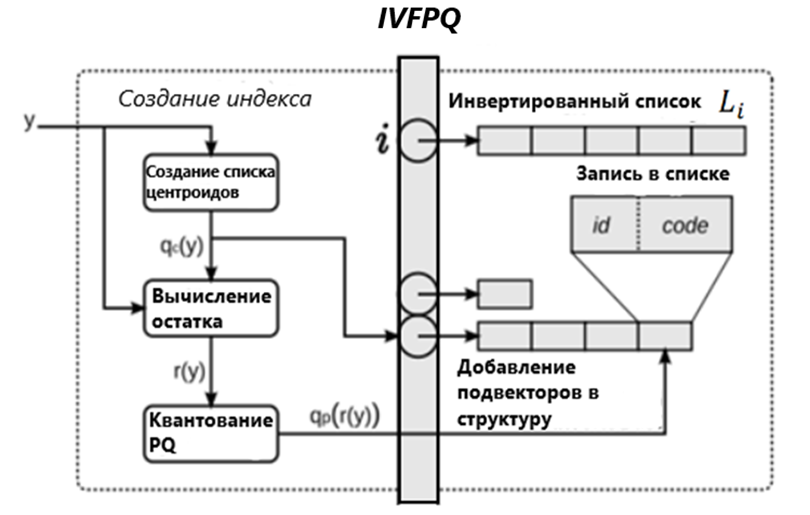

### Построение

In [ ]:
import pandas as pd
dataframe=pd.read_csv('путь до файла csv',index_col=0)
dataframe=np.array(dataframe)
index=IVFADC_DTW.train(dataframe,'количество кластеров','количество подкластеров','размер PQ-кода')

## Сохранение и загрузка индекса

In [ ]:
#Сохранить и загрузить индекс можно с помощью библиотеки pickle:
import pickle
with open("название индекса", "wb") as fp:   #Pickling
    pickle.dump(index, fp)
with open("название индекса", "rb") as fp:   # Unpickling
    index = pickle.load(fp)

## Поиск в индексе

### Схема поиска  

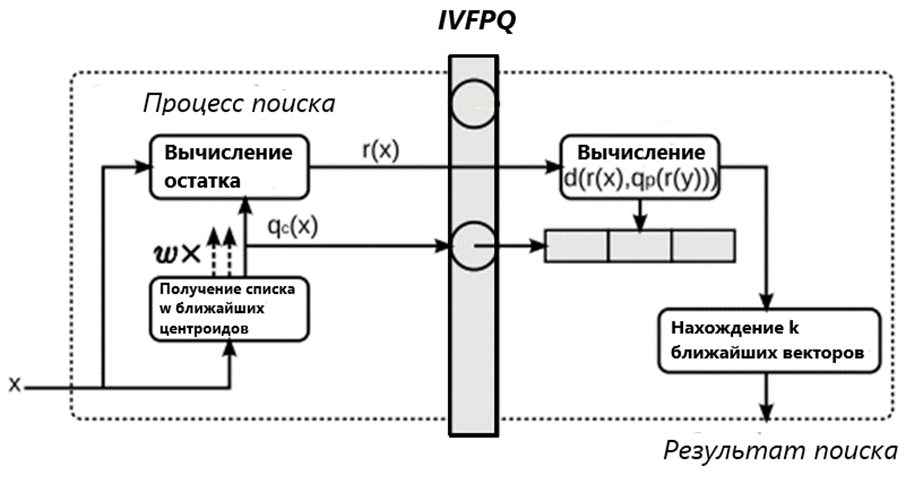

### Для DTW

In [ ]:
IVFADC_DTW.predict('вектор запроса','количество кластеров','количество соседей','размер PQ-кода (такой же, что и при создании индекса)',index)

### Для Евклидовой метрики

In [ ]:
IVFADC_EUCLIDIAN.predict('вектор запроса','количество кластеров','количество соседей','размер PQ-кода (такой же, что и при создании индекса)',index)